# Hello, MNIST!

In [1]:
from data.mnist import load_mnist

# Load the MNIST dataset
train_images, train_labels, test_images, test_labels = load_mnist()

# Print shapes to verify loading
print(f"Training images shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


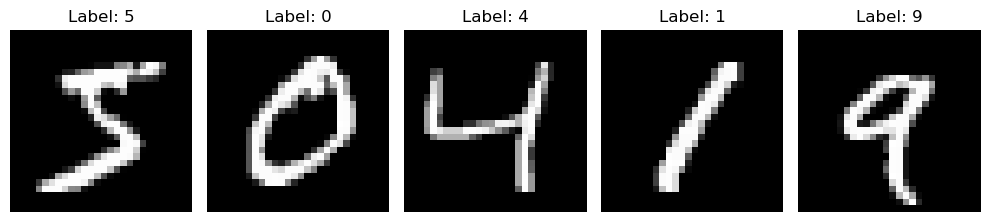

In [2]:
import matplotlib.pyplot as plt

# Create a figure with 5 subplots
fig, axes = plt.subplots(1, 5, figsize=(10, 3))

# Plot each image and its label
for i in range(5):
    axes[i].imshow(train_images[i], cmap='gray')
    axes[i].set_title(f'Label: {train_labels[i]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [3]:
import jax
import jax.numpy as jnp

def one_hot(x, k, dtype=jnp.float32):
    """Create a one-hot encoding of x of size k."""
    return jnp.array(x[:, None] == jnp.arange(k), dtype)

# Reshape images and convert labels
X_train = train_images.reshape(train_images.shape[0], -1).T
y_train = one_hot(train_labels, 10).T

# Get a batch
def get_batch(key, batch_size):
    idx = jax.random.choice(key, X_train.shape[1], shape=(batch_size,))
    return X_train[:, idx], y_train[:, idx]

In [4]:
from modula.atom import Linear
from modula.bond import ReLU

input_dim = 28 * 28
output_dim = 10
width = 256

mlp = Linear(output_dim, width) @ ReLU() @ Linear(width, width) @ ReLU() @ Linear(width, input_dim)
mlp.jit()

print(mlp)

CompositeModule
...consists of 3 atoms and 2 bonds
...non-smooth
...input sensitivity is 1
...contributes proportion 3 to feature learning of any supermodule


In [5]:
from tqdm.notebook import tqdm

from modula.error import SquareError

batch_size = 128
steps = 1000
learning_rate = 0.1

error = SquareError()

w = mlp.initialize(jax.random.PRNGKey(0))
w = mlp.project(w)
    
progress_bar = tqdm(range(steps), desc=f"Loss: {0:.4f}")
for step in progress_bar:
    key = jax.random.PRNGKey(step)
    inputs, targets = get_batch(key, batch_size)
    
    outputs, activations = mlp(inputs, w)
    loss = error(outputs, targets)
    error_grad = error.grad(outputs, targets)
    grad_w, _ = mlp.backward(w, activations, error_grad)
    d_w = mlp.dualize(grad_w)
    w = [weight - learning_rate * d_weight for weight, d_weight in zip(w, d_w)]
    progress_bar.set_description(f"Loss: {loss:.4f}")

Loss: 0.0000:   0%|          | 0/1000 [00:00<?, ?it/s]

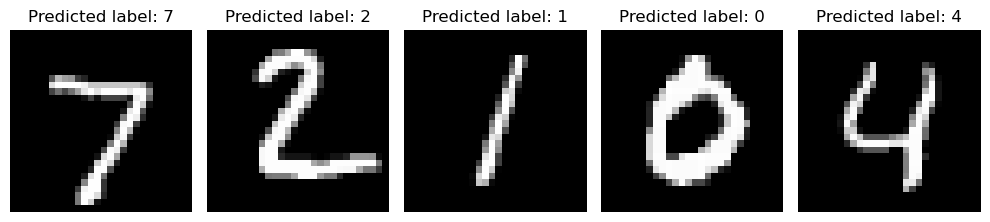

Accuracy on shown samples: 5/5
Overall test accuracy: 97.51%


In [6]:
# Get predictions for test images
X_test = test_images.reshape(test_images.shape[0], -1).T
test_outputs, _ = mlp(X_test, w)
predicted_labels = jnp.argmax(test_outputs, axis=0)

# Create a figure with subplots for multiple test images
n_samples = 5  # Number of test images to display
fig, axes = plt.subplots(1, n_samples, figsize=(10, 3))

# Plot each test image with true and predicted labels
for i in range(n_samples):
    axes[i].imshow(test_images[i], cmap='gray')
    true_label = test_labels[i]
    pred_label = int(predicted_labels[i])  # Convert from JAX array to integer
    axes[i].set_title(f'Predicted label: {pred_label}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Print accuracy for these samples
correct = (predicted_labels[:n_samples] == test_labels[:n_samples]).sum()
print(f"Accuracy on shown samples: {correct}/{n_samples}")

# Calculate and print overall test accuracy
total_correct = (predicted_labels == test_labels).sum()
total_samples = len(test_labels)
print(f"Overall test accuracy: {100 * total_correct/total_samples:.2f}%")